In [2]:
import json
import re 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from collections import Counter, defaultdict
from scipy import stats

from calibration_metric.vis.calibration_plot import plot_df
from calibration_metric.metric import ECEMetric

plt.rcParams["font.family"] = "Nimbus Roman"

from calibration_utils import (read_nucleus_file, 
                                read_gold_file,get_probs_and_accs, 
                                read_benchclamp_file, 
                                get_probs_and_accs_benchclamp,
                                get_probs_and_accs_sql)

/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


bart_data = read_benchclamp_file("/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl")
# bart_min_probs, bart_mean_probs, bart_accs = get_probs_and_accs_benchclamp(bart_data) 
bart_min_probs, bart_mean_probs, bart_accs = get_probs_and_accs_sql(bart_data) 

t5_data = read_benchclamp_file("/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-base-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230206T093954.jsonl") 
# t5_min_probs, t5_mean_probs, t5_accs = get_probs_and_accs_benchclamp(t5_data)
t5_min_probs, t5_mean_probs, t5_accs = get_probs_and_accs_sql(t5_data)

In [3]:
def bins_to_df(
    values: np.array,
    bin_edges: np.array,
    bin_number: np.array,
    ) -> pd.DataFrame:
    """
    Convert the output of bin_preds to a pandas dataframe.
    DataFrame has following columns:
    - prob_model: the probability for the bin
    - prob_correct: the average number of correct examples in the bin
    - count: the number of examples in the bin
    """
    # create LUT for bin number to number of items in that bin 
    bin_lookup = Counter(bin_number)
    # instantiate df 
    # df = pd.DataFrame(columns=["prob_model", "prob_correct", "count"])
    # populate df
    df_data = []
    for i, (val, edge_start, bin_num) in enumerate(zip(values, bin_edges, bin_number)):
        edge_end = bin_edges[i+1]
        midpoint = (edge_start + edge_end) / 2
        df_data.append({"prob_model": midpoint, 
                        "prob_correct": val, 
                        "count": bin_lookup[i+1]})
    df = pd.DataFrame.from_dict(df_data)
    df['normalized_count'] = df['count'] / df['count'].sum()
    df['log_count'] = np.log(df['count']) 
    # NOTE: this is not the same as the log of the normalized count; it is intended to
    # discount high count bins.
    df['normalized_log_count'] = df['log_count'] / df['log_count'].sum()
    return df

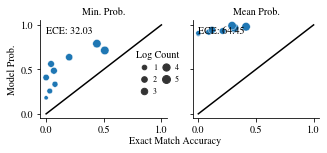

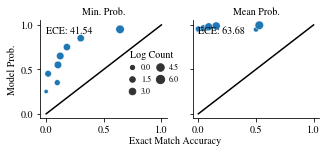

In [10]:
def comparison_plot(min_probs, mean_probs, accs, path, n_bins = 10):
    (min_values, 
    min_bins, 
    min_bin_number) = stats.binned_statistic(
        min_probs, 
        accs, 
        statistic='mean', 
        bins=n_bins)

    min_df_to_plot = bins_to_df(min_values, min_bins, min_bin_number)
    min_ece = ECEMetric(n_bins=n_bins)(np.array(min_probs), np.array(accs))
    min_ece *= 100


    (mean_values, 
    mean_bins, 
    mean_bin_number) = stats.binned_statistic(
        mean_probs, 
        accs, 
        statistic='mean', 
        bins=n_bins)

    mean_df_to_plot = bins_to_df(mean_values, mean_bins, mean_bin_number)
    mean_ece = ECEMetric(n_bins=n_bins)(np.array(mean_probs), np.array(accs))
    mean_ece *= 100

    fig, ax = plt.subplots(1,2, figsize=(5,1.8), sharex=True, sharey=True)
    metric_kwargs = {"x": 0.000, "y": 0.9, "fontsize": 10, "horizontalalignment": "left"}

    ax[0].set_title("Min. Prob.", fontsize=10)
    ax[1].set_title("Mean Prob.", fontsize=10)
    plot = plot_df(min_df_to_plot, ylabel="Model Prob.", xlabel=None, ax = ax[0], show_legend=False, metric_value=min_ece, metric_value_kwargs = metric_kwargs)
    plot = plot_df(mean_df_to_plot, ylabel="Model Prob.", xlabel=None, ax=ax[1], show_legend=False, metric_value=mean_ece, metric_value_kwargs=metric_kwargs) 
    # ax[0].set_xlabel("EM Accuracy", fontsize=10) # , bbox = {"xy": (0.7,0.0)})
    fig.text(0.5, -0.05, "Exact Match Accuracy", ha="center", va="center", fontsize=10)

    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=8, ncol=2, title="Log Count", frameon=False, bbox_to_anchor=(0.53, 0.71), handletextpad=0.1, columnspacing=0.1)

    # plt.tight_layout()
    # plt.savefig("/home/estengel/papers/did-you-mean-2022/figures/seq_calibration.pdf", bbox_inches='tight')
    if path is not None:
        plt.savefig(path, bbox_inches='tight')
    return min_values, min_bins, min_bin_number



bart_values, bart_bins, bart_bin_number = comparison_plot(bart_min_probs, bart_mean_probs, bart_accs, None, n_bins=9)
t5_values, t5_bins, t5_bin_number = comparison_plot(t5_min_probs, t5_mean_probs, t5_accs, None, n_bins=8)